<H2>Youtube Big Data Analysis

Generated end-to-end ETL pipelines and created Data Lake for Youtube data using AWS S3 for storage, AWS Glue for data catalog, AWS Athena to standardize the structure of the files and to run standalone python scripts, and AWS Quicksight to fetch that database to a dashboard.    

In this Jupyter notebook, we utilize the same data (both csv and json) to perform aditional analysis on trending video and atlast create a Regression Model using LinearRegression to predict number of likes on video

In [71]:
import boto3
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff


In [72]:
s3_client = boto3.resource('s3')
regions = ['ca', 'us', 'gb']
bucket = "dsde6002-finalproject-cleansed"
bucket_obj = s3_client.Bucket(bucket)

In [86]:
df = pd.read_csv('s3://dsde6002-finalproject-raw/youtube/raw_statistics/region=us/USvideos.csv')
df_cat = pd.read_json('s3://dsde6002-finalproject-raw/youtube/raw_statistics_reference_data/US_category_id.json')

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

In [88]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [89]:
# Transforming Trending date column to datetime format
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m').dt.date

# Transforming Trending date column to datetime format and splitting into two separate ones
publish_time = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
df['publish_date'] = publish_time.dt.date
df['publish_time'] = publish_time.dt.time
df['publish_hour'] = publish_time.dt.hour

In [90]:
# We'll use a very nice python featur - dictionary comprehension, to extract most important data from US_category_id.json
categories = {category['id']: category['snippet']['title'] for category in df_cat['items']}

# Now we will create new column that will represent name of category
df.insert(4, 'category', df['category_id'].astype(str).map(categories))

In [91]:
df['dislike_percentage'] = df['dislikes'] / (df['dislikes'] + df['likes'])

In [92]:
# Helper function
def numberOfUpper(string):
    i = 0
    for word in string.split():
        if word.isupper():
            i += 1
    return(i)

df["all_upper_in_title"] = df["title"].apply(numberOfUpper)

In [93]:
df['likes_log'] = np.log(df['likes'] + 1)
df['views_log'] = np.log(df['views'] + 1)
df['dislikes_log'] = np.log(df['dislikes'] + 1)
df['comment_log'] = np.log(df['comment_count'] + 1)

In [94]:
df_last = df.drop_duplicates(subset=['video_id'], keep='last', inplace=False)
df_first = df.drop_duplicates(subset=['video_id'], keep='first', inplace=False)

In [95]:
print("us_videos dataset contains {} videos".format(df.shape[0]))
print("us_videos_first dataset contains {} videos".format(df_first.shape[0]))
print("us_videos_last dataset contains {} videos".format(df_last.shape[0]))

us_videos dataset contains 40949 videos
us_videos_first dataset contains 6351 videos
us_videos_last dataset contains 6351 videos


In [96]:
df_first["time_to_trend"] = (df_first.trending_date - df_first.publish_date) / np.timedelta64(1, 'D')

<h3>Best time to Publish a Video

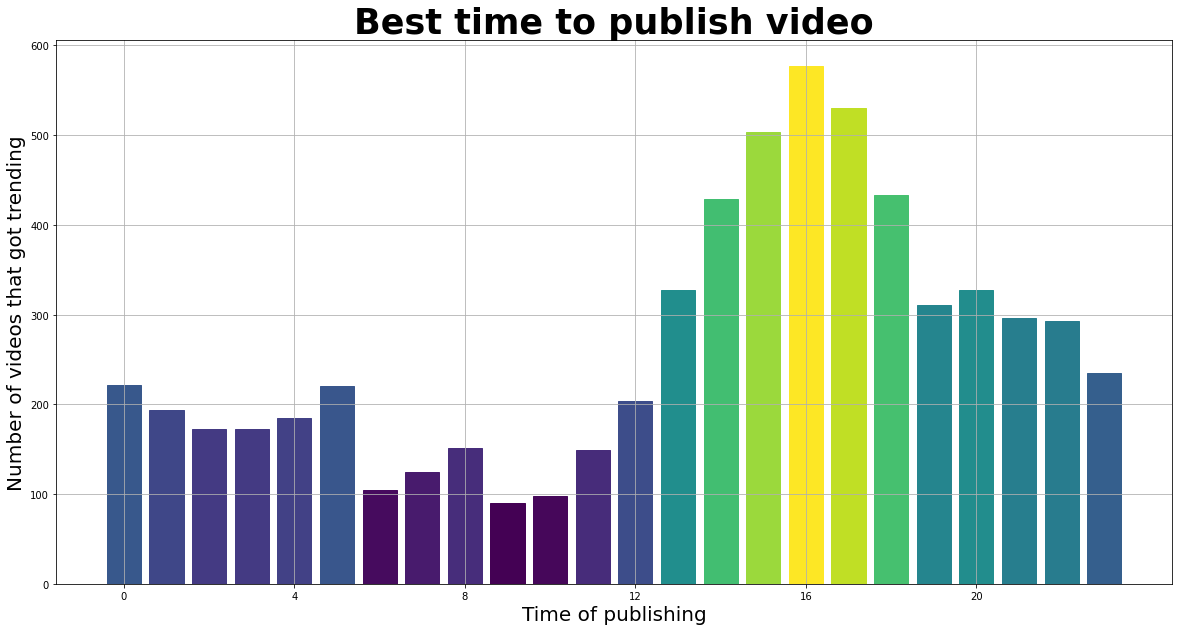

In [104]:
# Initialization of the list storing counters for subsequent publication hours
publish_h = [0] * 24

for index, row in df_first.iterrows():
    publish_h[row["publish_hour"]] += 1
    
values = publish_h
ind = np.arange(len(values))


# Creating new plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.yaxis.grid()
ax.xaxis.grid()
bars = ax.bar(ind, values)

# Sampling of Colormap

for i, b in enumerate(bars):
    b.set_color(plt.cm.viridis((values[i] - min(values))/(max(values)- min(values))))
    
plt.ylabel('Number of videos that got trending', fontsize=20)
plt.xlabel('Time of publishing', fontsize=20)
plt.title('Best time to publish video', fontsize=35, fontweight='bold')
plt.xticks(np.arange(0, len(ind), len(ind)/6), [0, 4, 8, 12, 16, 20])

plt.show()

<h3> Most influential Creators

In [122]:
max_title_length = 30
number_of_creators = 25

top_creators = df.groupby(['channel_title'])['channel_title'].agg(
    code_count=len).sort_values(
    "code_count", ascending=False
).head(number_of_creators).reset_index()

trace1 = go.Bar(
    y = [(x if len(x) <= max_title_length else x[:max_title_length] + "...") for x in top_creators.channel_title.values][::-1],
    x = top_creators['code_count'].tolist()[::-1],
    name = "Top creators",
    orientation = 'h',
    marker=dict(
        color='rgba(55, 128, 191, 1)'
    ),
)

data = [trace1]

layout = go.Layout(
    title = 'Most influential creators',
    height=600,
    yaxis = dict(
        anchor = 'x',
        rangemode='tozero',
        tickfont=dict(
            size=10
        ),
        ticklen=1
    ), 
    xaxis = dict(
        title= 'Number of times video made by creator got trending',
        anchor = 'x',
        rangemode='tozero'
    ), 
    legend=dict(x=0.6, y=0.07)
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

<H3>Most popular Categories

In [128]:
max_title_length = 30
number_of_creators = 10

top_creators = df.groupby(['category'])['category'].agg(
    code_count=len).sort_values(
    "code_count", ascending=False
).head(number_of_creators).reset_index()

trace1 = go.Bar(
    y = [(x if len(x) <= max_title_length else x[:max_title_length] + "...") for x in top_creators.category.values][::-1],
    x = top_creators['code_count'].tolist()[::-1],
    name = "Top categories",
    orientation = 'h',
    marker=dict(
        color='rgba(55, 128, 191, 1)',
    ),
)

data = [trace1]

layout = go.Layout(
    title = 'Most popular categories',
    height=600,
    yaxis = dict(
        anchor = 'x',
        rangemode='tozero',
        tickfont=dict(
            size=10
        ),
        ticklen=1
    ), 
    xaxis = dict(
        title= 'The number of times the video of a given category was trending',
        anchor = 'x',
        rangemode='tozero'
    ), 
    legend=dict(x=0.6, y=0.07)
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [135]:
max_title_length = 20
number_of_late_bloomers = 20

late_bloomers = df_first.sort_values(["time_to_trend"], ascending=False).head(number_of_late_bloomers)
late_bloomers_title = [(x if len(x) <= max_title_length else x[:max_title_length] + "...") for x in late_bloomers.title.values]
late_bloomers_days = late_bloomers.time_to_trend.values
late_bloomers_views = late_bloomers.views.values

trace1 = go.Bar(
    x = late_bloomers_title,
    y = late_bloomers_days,
    name='Number of days',
    marker=dict(
        color='rgba(55, 128, 191, 1)',
    )
)
trace2 = go.Bar(
    x = late_bloomers_title,
    y = late_bloomers_views,
    name='total views',
    marker=dict(
        color='rgba(219, 64, 82, 1)',
    ),
    yaxis='y2'
)


data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    title = 'Longest duraion before becoming Trending',
    height=500,
    yaxis = dict(
        title= 'Number of days until becoming trending',
        anchor = 'x',
        rangemode='tozero'
    ),   
    yaxis2=dict(
        title='Total number of views',
        overlaying='y',
        side='right',
        anchor = 'x',
        rangemode = 'tozero',
        dtick = 61000
    ),
    legend=dict(x=1, y=1.2)
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

<H3> Likes vs Dislikes

In [145]:
max_title_length = 20
number_of_late_bloomers = 10

most_disliked = df_first.sort_values(["dislikes"], ascending=False).head(number_of_late_bloomers)
most_disliked_title = [(x if len(x) <= max_title_length else x[:max_title_length] + "...") for x in late_bloomers.title.values]
most_disliked_l_number = most_disliked.likes.values
most_disliked_dl_number = most_disliked.dislikes.values
most_disliked_dl_percentage = most_disliked.dislike_percentage.values

trace1 = go.Bar(
    x = most_disliked_title,
    y = most_disliked_l_number,
    name='Number of likes',
    marker=dict(
        color='rgba(55, 128, 191, 1)',
    )
)
trace2 = go.Bar(
    x = most_disliked_title,
    y = most_disliked_dl_number,
    name='Number of dislikes',
    marker=dict(
        color='rgba(219, 64, 82, 1)',
    )
)

trace3 = go.Scatter(
    x = most_disliked_title,
    y = most_disliked_dl_percentage,
    name='Dislike percentage',
    mode = 'markers',
    marker=dict(
        symbol="hexagon-dot",
        size=15
    ),
    yaxis='y2'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group',
    title = 'No such thing as bad press, right?',
    height=600,
    yaxis = dict(
        title= 'Number of likes/dislikes',
        anchor = 'x',
        rangemode='tozero'
    ),   
    yaxis2=dict(
        title='Dislike percentage',
        overlaying='y',
        side='right',
        anchor = 'x',
        rangemode = 'tozero',
        dtick = 0.165
    ),
    legend=dict(x=1, y=1)
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

<H3> Log distribution of Likes vs Dislikes

In [146]:
hist_data = [df_first["dislikes_log"].values, df_first["likes_log"].values]

group_labels = ['Dislikes log distribution', 'Likes log distribution']
colors = ['#A6ACEC', '#63F5EF']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, colors=colors,
                         bin_size=0.5, show_rug=False)

# Add title
fig['layout'].update(title='Likes vs dislikes', legend=dict(x=0.65, y=0.8))

# Plot!
py.iplot(fig, filename='Hist and Curve')

In [147]:
df.isnull().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category                    0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
publish_date                0
publish_hour                0
dislike_percentage        170
all_upper_in_title          0
likes_log                   0
views_log                   0
dislikes_log                0
comment_log                 0
dtype: int64

In [148]:
df1 = df.drop(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'], axis=1) # Deleting column
df1.head()

,category,views,likes,dislikes,comment_count,publish_date,publish_hour,dislike_percentage,all_upper_in_title,likes_log,views_log,dislikes_log,comment_log
0,People & Blogs,748374,57527,2966,15954,2017-11-13,17,0.049030,7,10.960027,13.525659,7.995307,9.677528
1,Entertainment,2418783,97185,6146,12703,2017-11-13,7,0.059479,1,11.484382,14.698775,8.723719,9.449672
2,Comedy,3191434,146033,5339,8181,2017-11-12,19,0.035271,0,11.891595,14.975981,8.582981,9.009692
3,Entertainment,343168,10172,666,2146,2017-11-13,11,0.061450,0,9.227492,12.745978,6.502790,7.671827
4,Entertainment,2095731,132235,1989,17518,2017-11-12,18,0.014819,3,11.792343,14.555413,7.595890,9.771041


<AxesSubplot:>

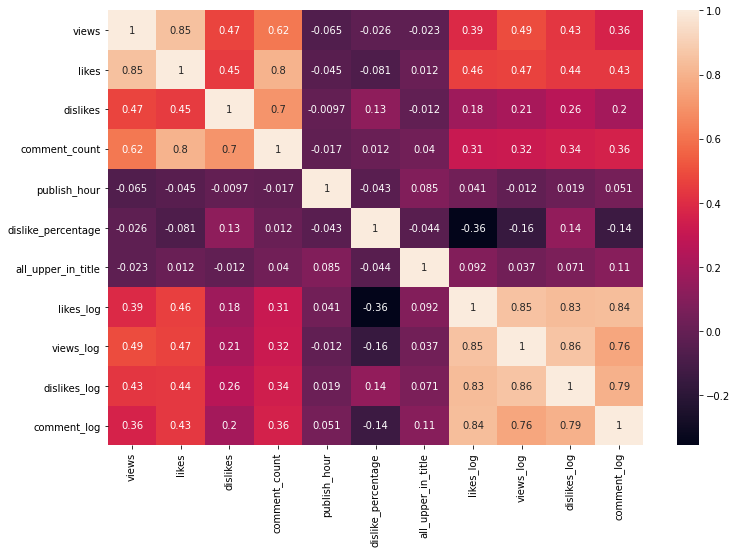

In [150]:
plt.figure(figsize=(12,8))
corr = df1.corr()

sns.heatmap(corr, annot=True)

In [152]:
from sklearn.model_selection import train_test_split
X = df1[['views', 'dislikes', 'comment_count']]
y = df1['likes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

In [153]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics

In [155]:
lm = LinearRegression()
lm.fit(X_train, y_train)      # Fitting model with x_train and y_train
lm_pred = lm.predict(X_test)  # Predicting the results
print('RMSE:', np.sqrt(mean_squared_error(y_test, lm_pred, squared=False)))
print('r2 score: %.2f' % r2_score(y_test, lm_pred))
print("Accuracy :",lm.score(X_test, y_test))

RMSE: 272.56266438517713
r2 score: 0.89
Accuracy : 0.8914748717455828


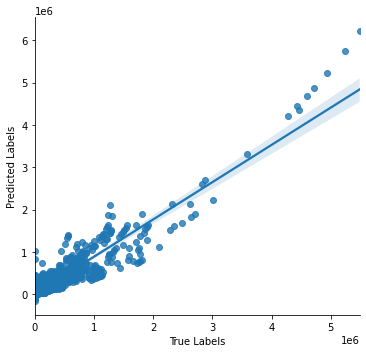

In [156]:
labels = {'True Labels': y_test, 'Predicted Labels': lm_pred}
df_lm = pd.DataFrame(data = labels)
sns.lmplot(x='True Labels', y= 'Predicted Labels', data = df_lm)

We have used Multiple Linear Regression for the YouTube USVideos dataset. The linear Regression model provided a good result. The R2 score value is close to 1.0 and accuracy is also above average.

1. RMSE: 272.56
2. R2 Score: 0.89
3. Accuracy: 89.14 %

Shows the lmplot, which fits the regression model with conditional parameters, and it can be observed that a straight line can be drawn.